In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xarray as xr


In [2]:
np.random.seed(50) #for reproducibility


N = 1000
time = np.arange(N)  
data_no = np.random.normal(loc=0,scale=1, size=N)  
data_ex = np.random.exponential(scale=1.0, size=N)  

The Pearson coefficient (normalized covariance) requires that our time series be normal (Gaussian distribution), stationary (statistics unchanging over time), and that each sample be independent from the others. <br />
The first thing to consider is the normal distribution. I have generated two random series, one with a Gaussian distribution and one with a non-Gaussian distribution.

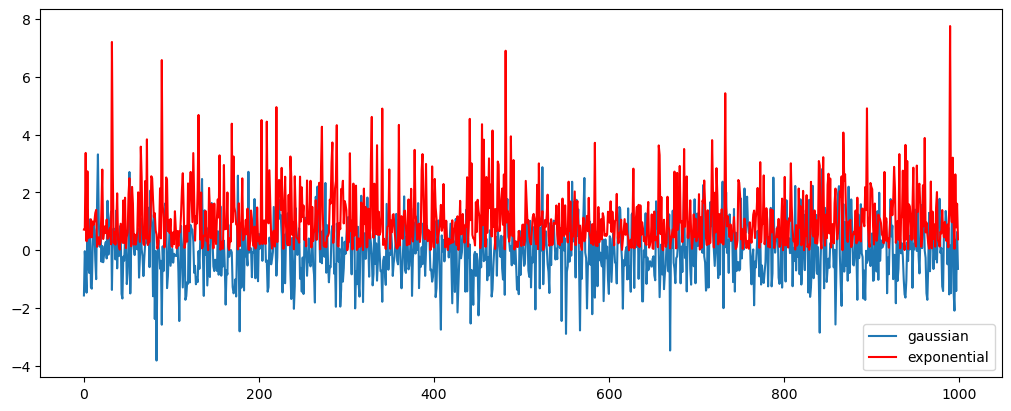

In [3]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(data_no,label='gaussian')
ax.plot(data_ex,label='exponential',color='r')
ax.legend()

I used the seaborn histplot function with kde=TRUE to create a smoothed curve over the histogram that represents the probability density function. This clearly shows that the two distributions are different. Furthermore, I applied a Shapiro-Wilk test to confirm the normality of the data. If p < 0.05, the data is not normally distributed.

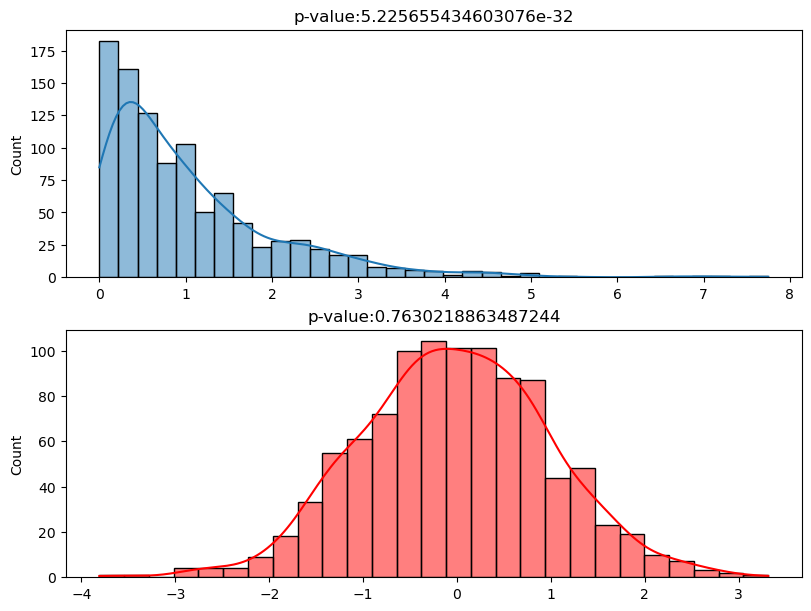

In [4]:
shapiro_ex = stats.shapiro(data_ex)
shapiro_no = stats.shapiro(data_no)



fig, axs = plt.subplots(2,1,figsize=(8,6), constrained_layout=True)
sns.histplot(data_ex,kde=True,ax=axs[0])
axs[0].set_title('p-value:'+ str(shapiro_ex.pvalue))

sns.histplot(data_no,kde=True,ax=axs[1],color='r')
axs[1].set_title('p-value:'+ str(shapiro_no.pvalue));


There are methods to transform non-Gaussian distributions into Gaussian. Boxcox worked perfectly!

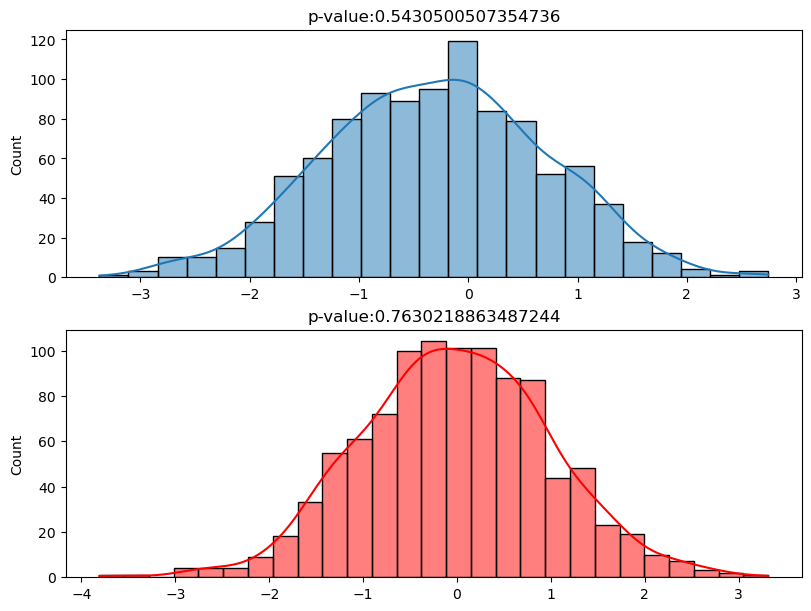

In [5]:
from scipy.stats import boxcox

shapiro_ex2 = stats.shapiro(boxcox(data_ex)[0])
shapiro_no = stats.shapiro(data_no)



fig, axs = plt.subplots(2,1,figsize=(8,6), constrained_layout=True)
sns.histplot(boxcox(data_ex)[0],kde=True,ax=axs[0])
axs[0].set_title('p-value:'+ str(shapiro_ex2.pvalue))

sns.histplot(data_no,kde=True,ax=axs[1],color='r')
axs[1].set_title('p-value:'+ str(shapiro_no.pvalue));

Now, stationary means that if we take the variance or mean at any point in time, it should remain roughly unchanged. Take the next example, the horizontal black lines are the mean at two different times. For the blue line, the mean stays the same, but for the example with the trend, the mean changes over time. In this case, we need to detrend the data (sometimes we also need to remove the seasonal cycle).

In [6]:
a=1/100;
b=0;
x=np.arange(N)
trend=a*x+b;
data_no_trend=data_no+trend

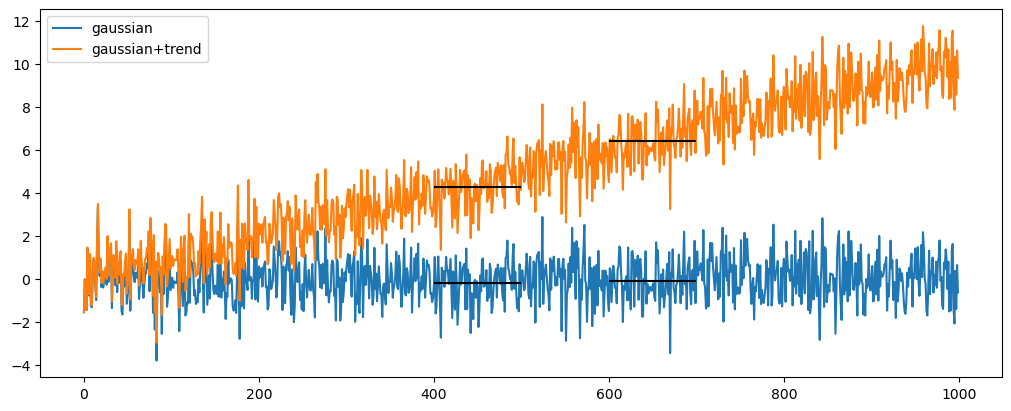

In [7]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(data_no,label='gaussian')
ax.plot(data_no_trend,label='gaussian+trend')
ax.hlines(np.mean(data_no[400:500]),400,500,'black')
ax.hlines(np.mean(data_no[600:700]),600,700,'black')
ax.hlines(np.mean(data_no_trend[400:500]),400,500,'black')
ax.hlines(np.mean(data_no_trend[600:700]),600,700,'black')

ax.legend()

In this idealized case with a linear trend, we can easily remove it in the following way.

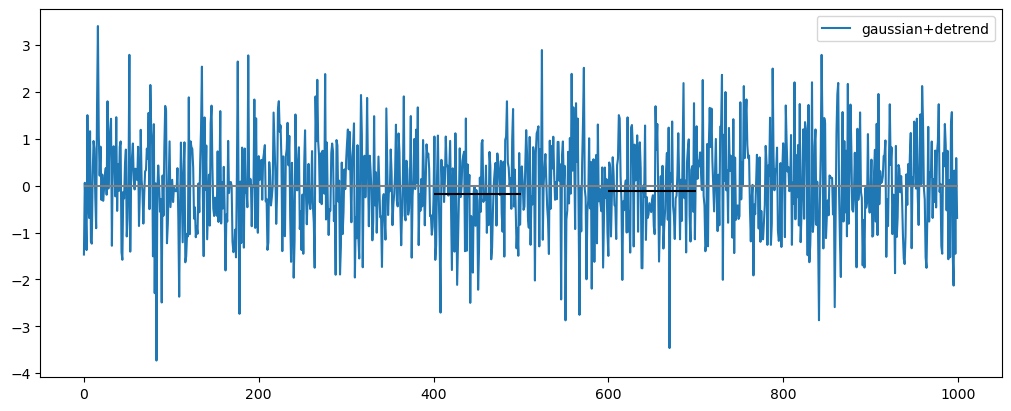

In [8]:
from scipy.signal import detrend


data_no_detrend = detrend(data_no_trend, type='linear')

fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)

ax.plot(data_no_detrend,label='gaussian+detrend')

ax.hlines(np.mean(data_no_detrend[400:500]),400,500,'black')
ax.hlines(np.mean(data_no_detrend[600:700]),600,700,'black')
ax.hlines(0,0,N,'gray')

ax.legend()

Independence, here I am using an autoregressive model to construct a time series with autocorrelation. 
$Y_{t}=\varphi Y_{t-1}+\epsilon_{t}$

In [9]:
def lag_autocorrelation(X, K):
    """Autocorrelation  with N-k"""
    N = len(X)
    Xmean = np.mean(X)
    Xvar = np.var(X)  
    autocorr = np.zeros(K + 1)
    
    for k in range(K+ 1):
        
        cov_sum = np.sum((X[:N - k] - Xmean) * (X[k:] - Xmean))
        # autocorr[k] = cov_sum / ((N - k) * Xvar) if Xvar != 0 else 0 
        autocorr[k] = cov_sum / ((N - k) * Xvar)
    
    return autocorr

In [10]:
lag = 1

r=0.6;

data_no2 = np.zeros(N)
data_no2[0] =  np.random.normal(loc=0, scale=1)

for t in range(1, N):
  
    data_no2[t] = r * data_no2[t - 1] + np.sqrt(1 - r**2) * np.random.normal(loc=0, scale=1)


In [11]:
np.var(data_no2)

0.9203927041884582

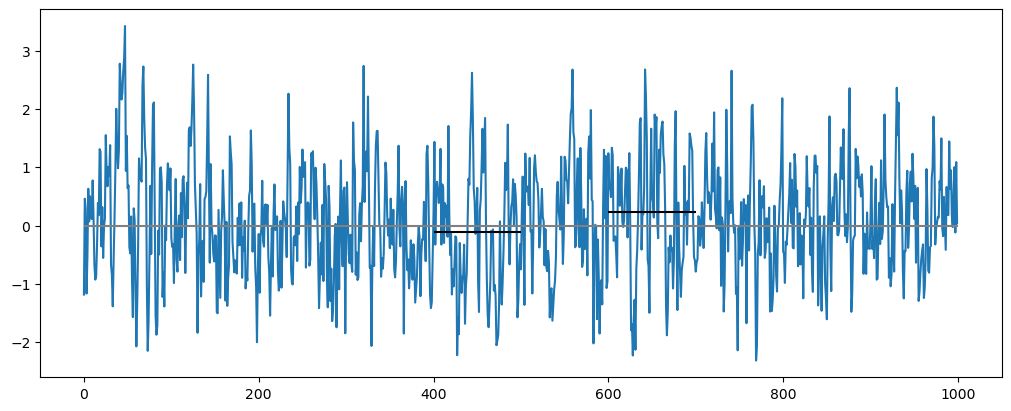

In [12]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)

ax.plot(data_no2,label='lag 1')

ax.hlines(np.mean(data_no2[400:500]),400,500,'black')
ax.hlines(np.mean(data_no2[600:700]),600,700,'black')
ax.hlines(0,0,N,'gray')

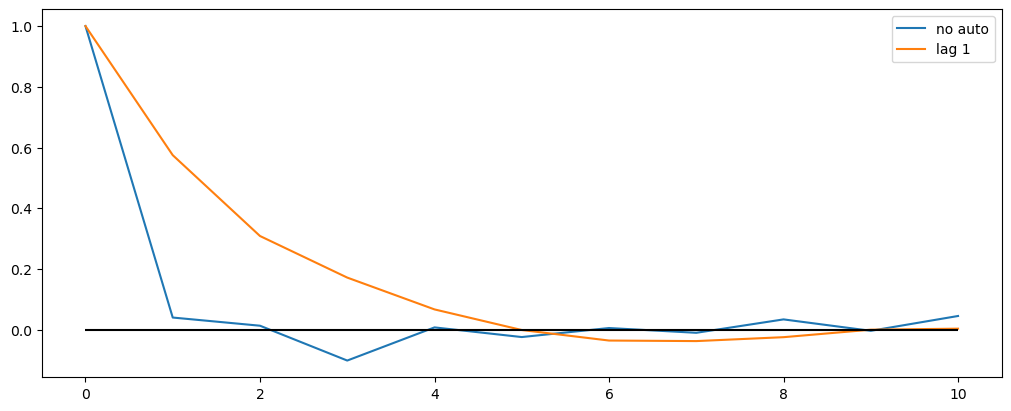

In [13]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(lag_autocorrelation(data_no,10),label='no auto')
ax.plot(lag_autocorrelation(data_no2,10),label='lag 1')
ax.hlines(0,0,10,'black')
ax.legend()